In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr

# DATA PREPARATION

Costruzione di attributi che caratterizzano il comportamento di un utente.

Si caricano i dati preprocessati, considerando per ora solo quelli con `CustomerID` non nullo:

In [2]:
df = pd.read_csv("../../preprocessed.csv", index_col=0)
df = df[~(df["CustomerID"].isnull())]
df["BasketDate"] = pd.to_datetime(df["BasketDate"])
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541904,581587,2011-09-12 12:50:00,0.85,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,12
541905,581587,2011-09-12 12:50:00,2.10,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,2011-09-12 12:50:00,4.15,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,2011-09-12 12:50:00,4.15,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4


## Estrazione degli indicatori

Si estraggono gli indicatori per ogni autore dai record del dataset

In [3]:
from indicators import customer_features

customer_indicators = df.groupby("CustomerID").apply(customer_features)
customer_indicators = pd.DataFrame(customer_indicators.values.tolist(), index=customer_indicators.index)
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E
CustomerID,,,,,,,
12347.0,164.571429,12.285714,416.905714,330,3.137986,7,6.217788
12348.0,6.000000,1.000000,240.000000,6,40.000000,1,0.000000
12349.0,465.000000,63.000000,1233.910000,465,3.714603,1,5.786721
12350.0,172.000000,15.000000,274.000000,172,1.630000,1,3.891479
12352.0,68.857143,7.857143,214.991429,103,5.148158,7,5.454556
...,...,...,...,...,...,...,...
18280.0,45.000000,10.000000,180.600000,45,4.765000,1,3.207542
18281.0,52.000000,5.000000,46.920000,52,1.092000,1,2.281445
18282.0,26.500000,4.500000,69.315000,28,4.066667,2,2.962478


In [4]:
customer_indicators.describe()

,I,Iu,spending,Imax,avg_bought,baskets,E
count,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000
mean,101.228624,13.745575,232.548074,146.372048,3.419600,3.940000,4.363661
std,86.226957,12.247100,203.760553,127.699879,4.274995,6.699954,1.643364
min,2.000000,0.200000,0.840000,2.000000,0.347500,1.000000,0.000000
25%,47.000000,6.000000,108.991250,61.000000,2.190041,1.000000,3.321256
50%,82.000000,10.732143,184.641771,115.000000,2.959688,2.000000,4.454893
75%,131.661765,17.666667,299.090536,194.000000,3.878626,4.000000,5.546482
max,1507.000000,202.000000,3343.190000,1507.000000,145.000000,191.000000,9.891737


In [5]:
customer_indicators.corr().abs().style.background_gradient(cmap='coolwarm')

,I,Iu,spending,Imax,avg_bought,baskets,E
I,1.000000,0.857035,0.891570,0.860799,0.105598,0.005706,0.569257
Iu,0.857035,1.000000,0.743712,0.676608,0.108110,0.112878,0.516087
spending,0.891570,0.743712,1.000000,0.774020,0.069966,0.004818,0.489669
Imax,0.860799,0.676608,0.774020,1.000000,0.099773,0.248725,0.731077
avg_bought,0.105598,0.108110,0.069966,0.099773,1.000000,0.018727,0.178723
baskets,0.005706,0.112878,0.004818,0.248725,0.018727,1.000000,0.421316
E,0.569257,0.516087,0.489669,0.731077,0.178723,0.421316,1.000000


## Scaling degl indicatori

Si applica all'intero dataset uno scaling della forma Min-Max

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

customer_indicators[customer_indicators.columns]=scaler.fit_transform(customer_indicators)
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E
CustomerID,,,,,,,
12347.0,0.108021,0.059890,0.124483,0.217940,0.019291,0.031579,0.628584
12348.0,0.002658,0.003964,0.071554,0.002658,0.274122,0.000000,0.000000
12349.0,0.307641,0.311199,0.368923,0.307641,0.023277,0.000000,0.585006
12350.0,0.112957,0.073340,0.081727,0.112957,0.008866,0.000000,0.393407
12352.0,0.044423,0.037944,0.064072,0.067110,0.033188,0.031579,0.551425
...,...,...,...,...,...,...,...
18280.0,0.028571,0.048563,0.053783,0.028571,0.030539,0.000000,0.324265
18281.0,0.033223,0.023786,0.013787,0.033223,0.005147,0.000000,0.230642
18282.0,0.016279,0.021308,0.020487,0.017276,0.025711,0.005263,0.299490


### Rimozione degli outliers

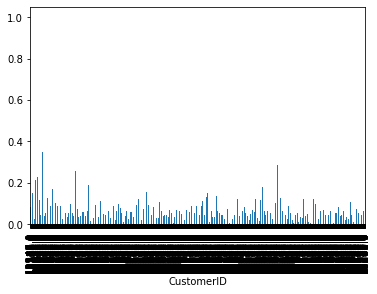

In [7]:
customer_indicators["spending"].plot.bar()

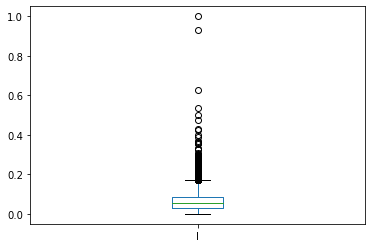

In [8]:
customer_indicators["I"].plot.box()

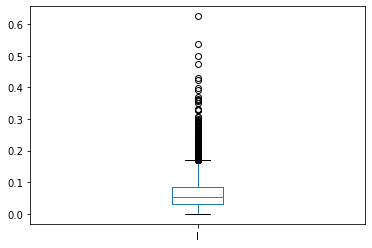

In [9]:
customer_indicators=customer_indicators[customer_indicators["I"]<0.8]
customer_indicators["I"].plot.box()

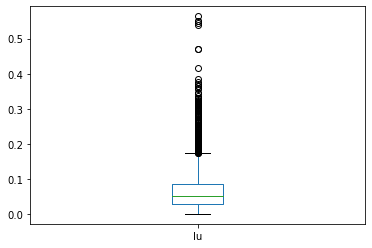

In [10]:
customer_indicators["Iu"].plot.box()

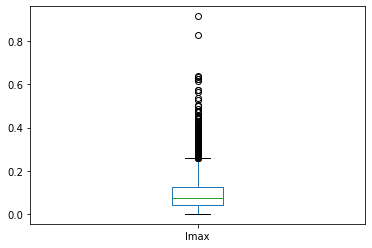

In [11]:
customer_indicators["Imax"].plot.box()

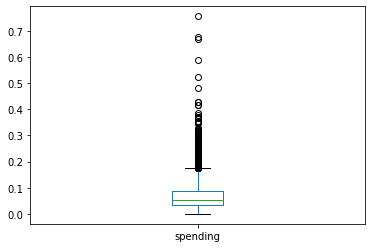

In [12]:
customer_indicators["spending"].plot.box()

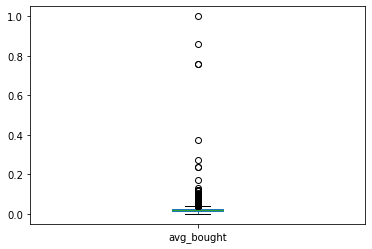

In [13]:
customer_indicators["avg_bought"].plot.box()

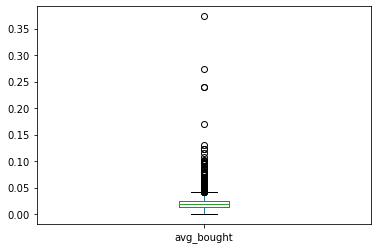

In [14]:
customer_indicators=customer_indicators[customer_indicators["avg_bought"]<0.6]
customer_indicators["avg_bought"].plot.box()

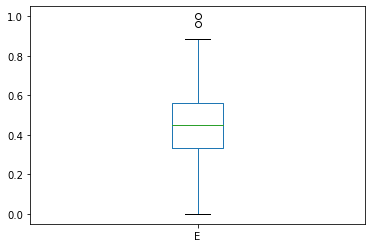

In [15]:
customer_indicators["E"].plot.box()

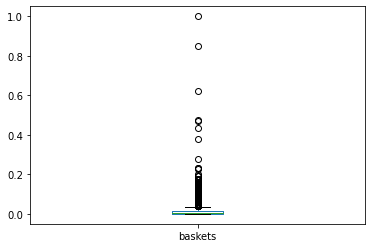

In [16]:
customer_indicators["baskets"].plot.box()

# K-Means


In [18]:
#dataset for k-means
X_KMeans=customer_indicators.copy()

#inverted dataset for printing  results 
X_KMeansForPrint=customer_indicators.copy()
X_KMeansForPrint[X_KMeansForPrint.columns]=scaler.inverse_transform(X_KMeansForPrint[X_KMeansForPrint.columns])

# Subtask 1.1: identificazione del valore K


K: 2
SSE 94.9484660932593
Silhouette 0.42682196566310493
Separation 0.838014272731308 

K: 3
SSE 66.82661408869426
Silhouette 0.37495076165181773
Separation 0.9356506550942867 

K: 4
SSE 52.37999760598225
Silhouette 0.3590125689160133
Separation 0.9578832878711283 

K: 5
SSE 44.188985583073716
Silhouette 0.3324428535842015
Separation 0.9551199664334492 

K: 10
SSE 26.86167644981441
Silhouette 0.2856530639573769
Separation 0.9746810257682222 

K: 15
SSE 19.9919512714466
Silhouette 0.26201958200324205
Separation 1.072773467929723 

K: 20
SSE 16.655773835064636
Silhouette 0.2623659591233463
Separation 1.0889399914544458 



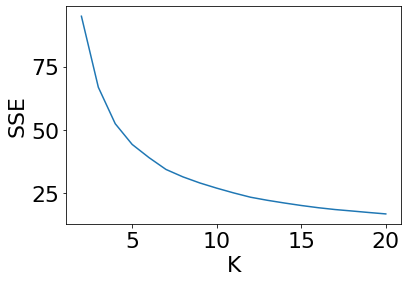

[94.9484660932593, 66.82661408869426, 52.37999760598225, 44.188985583073716, 38.94110437454063, 34.274525933140445, 31.335106848687616, 28.921537170680338, 26.86167644981441, 24.981673777479088, 23.270411198418525, 22.04954518133431, 20.982236081953314, 19.9919512714466, 19.11790220307993, 18.387527022590287, 17.811588279590797, 17.214069519651428, 16.655773835064636]


In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics
sse_list = list()
max_k = 20
start_k=2
for k in range(start_k, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=30, max_iter=100)
    kmeans.fit(X_KMeans)
    
    sse = kmeans.inertia_
    sse_list.append(sse)
    
    if((k%5==0) or k<5):
        print("K: "+str(k))
        print('SSE %s' % kmeans.inertia_)
        print('Silhouette %s' % metrics.silhouette_score(X_KMeans, kmeans.labels_))
        print('Separation %s \n' % metrics.davies_bouldin_score(X_KMeans, kmeans.labels_))
        

plt.plot(range(start_k, max_k + 1), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()


print(sse_list)

In [20]:
kmeans = KMeans(n_clusters=3, n_init=30, max_iter=100)
kmeans.fit(X_KMeans)
    

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % metrics.silhouette_score(X_KMeans, kmeans.labels_))
print('Separation %s \n' % metrics.davies_bouldin_score(X_KMeans, kmeans.labels_))

SSE 66.82864887390177
Silhouette 0.3752733150987698
Separation 0.9355704711121632 



# Subtask 1.2: descrizione dei cluster ottenuti

In [22]:
centers = (kmeans.cluster_centers_)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

#I	Iu	spending	Imax	avg_bought	baskets	E

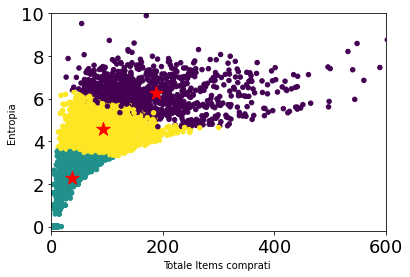

In [23]:
plt.scatter(X_KMeansForPrint['I'], X_KMeansForPrint['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:,6], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.2, 600)
plt.ylim(-0.2,10)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

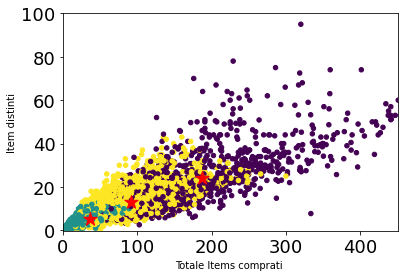

In [25]:
plt.scatter(X_KMeansForPrint['I'], X_KMeansForPrint['Iu'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.2, 450)
plt.ylim(-0.2,100)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Item distinti')
plt.show()

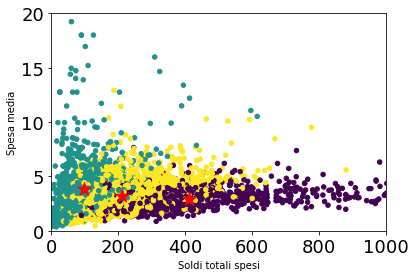

In [26]:
#I	Iu	spending	Imax	avg_bought	baskets	E
plt.scatter(X_KMeansForPrint['spending'], X_KMeansForPrint['avg_bought'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 2], centers[:,4], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.2, 1000)
plt.ylim(-0.01,20)
plt.xlabel('Soldi totali spesi')
plt.ylabel('Spesa media')
plt.show()

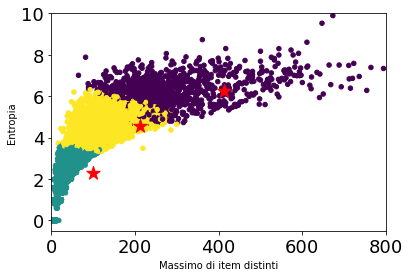

In [27]:
#I	Iu	spending	Imax	avg_bought	baskets	E
plt.scatter(X_KMeansForPrint['Imax'], X_KMeansForPrint['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 2], centers[:, 6], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.2, 800)
plt.ylim(-0.5,10)
plt.xlabel('Massimo di item distinti')
plt.ylabel('Entropia')
plt.show()

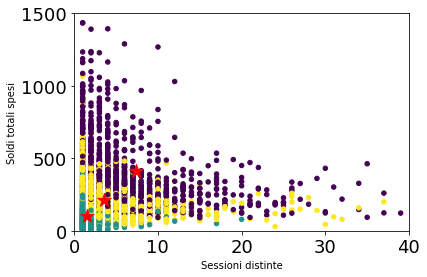

In [28]:
plt.scatter(X_KMeansForPrint['baskets'], X_KMeansForPrint['spending'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 5], centers[:, 2], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.01, 40)
plt.ylim(-0.01,1500)
plt.xlabel('Sessioni distinte')
plt.ylabel('Soldi totali spesi')
plt.show()

In [29]:
centers

array([[187.18838417,  24.34719352, 411.78447859, 304.08912831,
          2.91364442,   7.40058766,   6.26943235],
       [ 36.77409989,   5.16248754,  99.24543432,  40.94986571,
          3.86234422,   1.56311549,   2.28969396],
       [ 92.21225378,  12.9776429 , 212.30140376, 123.78015952,
          3.19338054,   3.5109671 ,   4.55419434]])

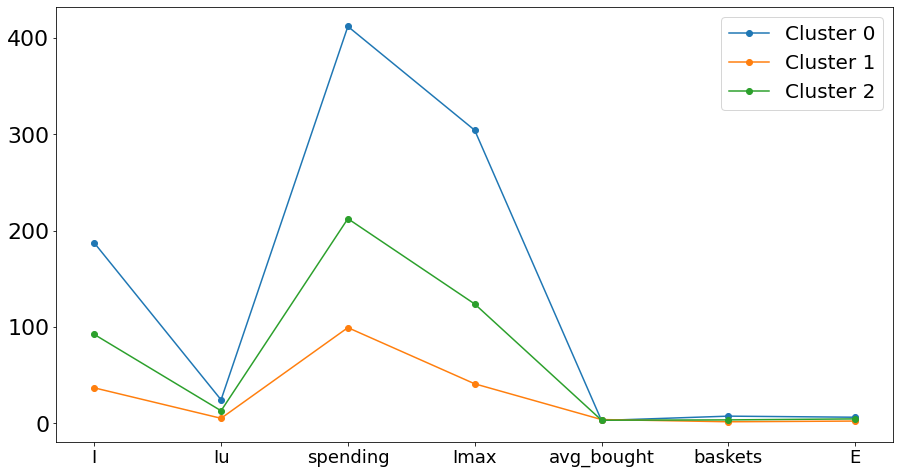

In [30]:
plt.figure(figsize=(15, 8))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(X_KMeansForPrint.columns)), X_KMeansForPrint.columns, fontsize=18)
plt.legend(fontsize=20)
plt.show()

Zoom nella parte bassa del grafico

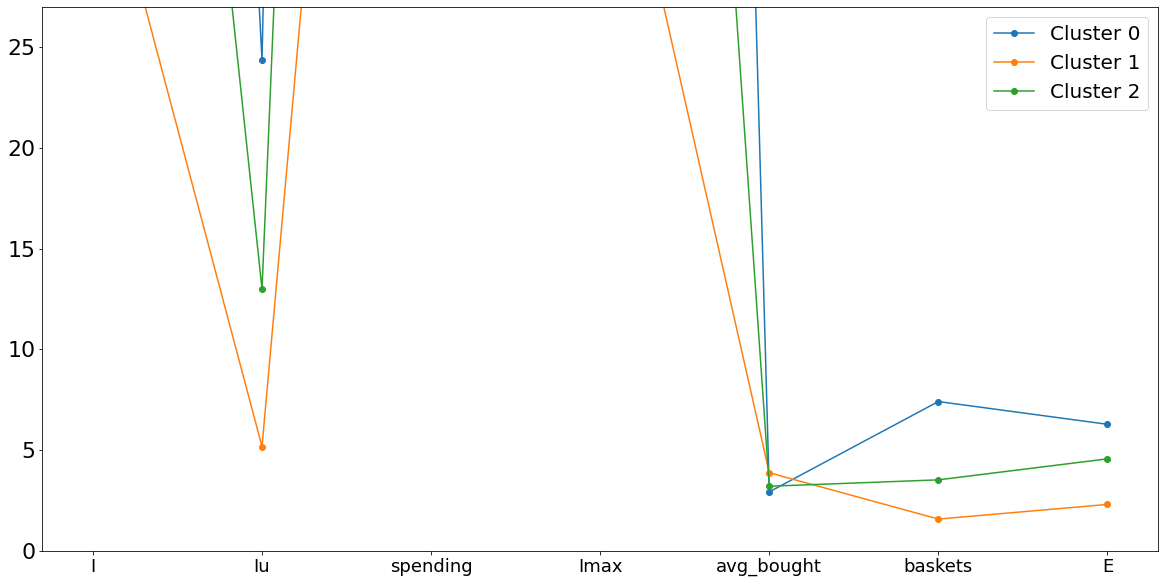

In [35]:
plt.figure(figsize=(20, 10))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(X_KMeansForPrint.columns)), X_KMeansForPrint.columns, fontsize=18)
plt.legend(fontsize=20)
plt.ylim(0,27)
plt.show()

# Density based clustering

In [36]:
#dataset for DBscan
X_DBScan=customer_indicators.copy()

#inverted dataset for printing  results 
X_DBScanForPrint=customer_indicators.copy()
X_DBScanForPrint[X_DBScanForPrint.columns]=scaler.inverse_transform(X_DBScanForPrint[X_DBScanForPrint.columns])

In [37]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

dist = pdist(X_DBScan, 'euclidean') 
dist = squareform(dist) 
dist.shape

(4144, 4144)

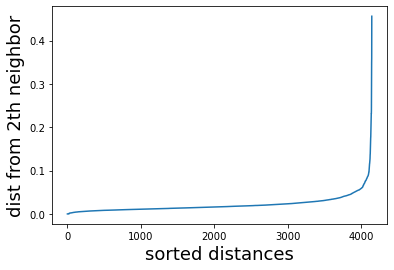

K = 2 
k-dist del 4000-esimo punto 0.05900574192326568: 
k-dist del 3000-esimo punto 0.023354557933182463: 


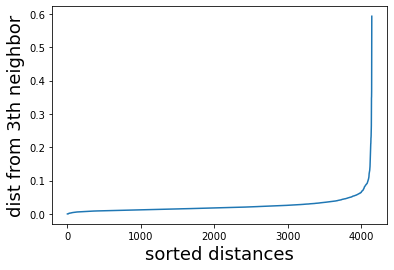

K = 3 
k-dist del 4000-esimo punto 0.06479384380576535: 
k-dist del 3000-esimo punto 0.02588331495683801: 


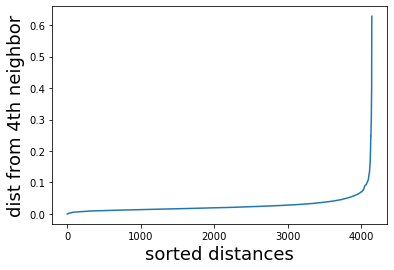

K = 4 
k-dist del 4000-esimo punto 0.06999764541790579: 
k-dist del 3000-esimo punto 0.027985657695470373: 


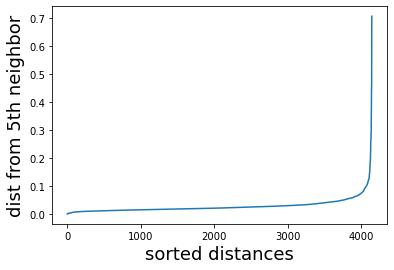

K = 5 
k-dist del 4000-esimo punto 0.07444863123485393: 
k-dist del 3000-esimo punto 0.02964176115372422: 


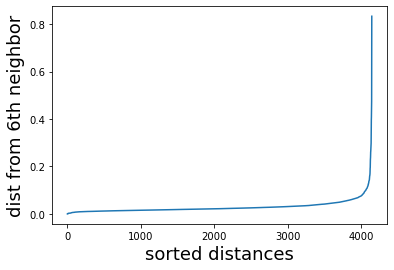

K = 6 
k-dist del 4000-esimo punto 0.07652118773928145: 
k-dist del 3000-esimo punto 0.030992158571137487: 


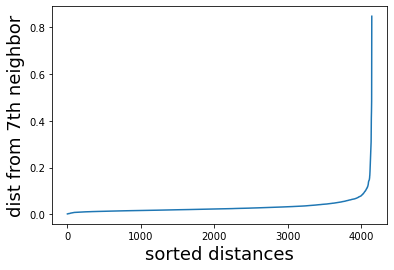

K = 7 
k-dist del 4000-esimo punto 0.08003578251717183: 
k-dist del 3000-esimo punto 0.032274149214512084: 


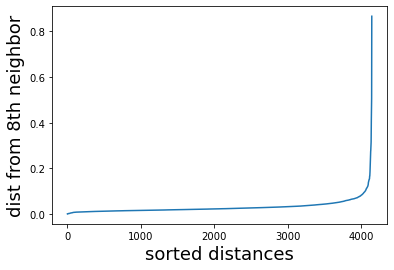

K = 8 
k-dist del 4000-esimo punto 0.08361449333781569: 
k-dist del 3000-esimo punto 0.033259050521581686: 


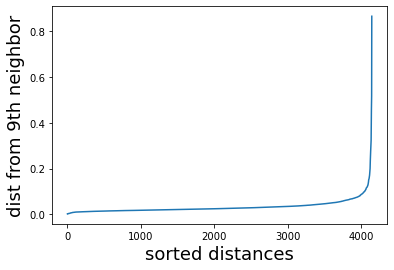

K = 9 
k-dist del 4000-esimo punto 0.08674752768161915: 
k-dist del 3000-esimo punto 0.03428023643499472: 


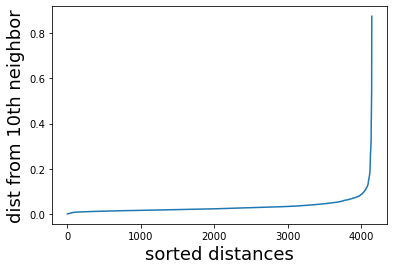

K = 10 
k-dist del 4000-esimo punto 0.08850131792039144: 
k-dist del 3000-esimo punto 0.0352372019988417: 


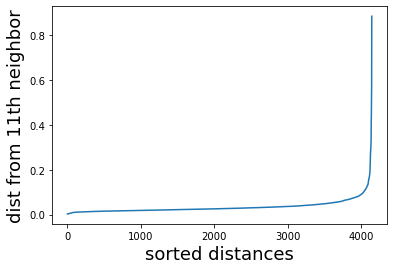

K = 11 
k-dist del 4000-esimo punto 0.09070954319979717: 
k-dist del 3000-esimo punto 0.0358950371005426: 


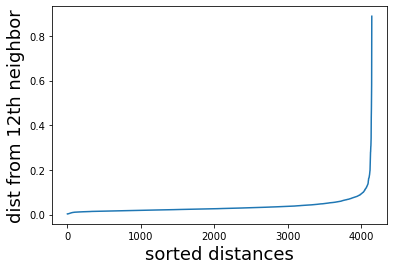

K = 12 
k-dist del 4000-esimo punto 0.09268341854829448: 
k-dist del 3000-esimo punto 0.03660983109809758: 


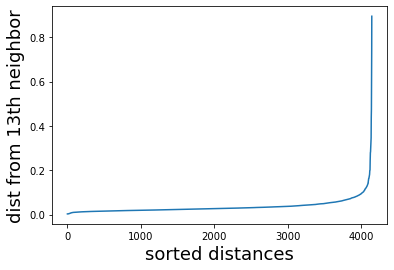

K = 13 
k-dist del 4000-esimo punto 0.09449779817652691: 
k-dist del 3000-esimo punto 0.037292492488715454: 


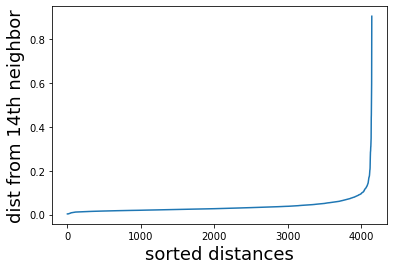

K = 14 
k-dist del 4000-esimo punto 0.09622004384448449: 
k-dist del 3000-esimo punto 0.03795998564407215: 


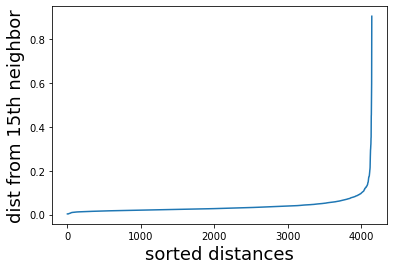

K = 15 
k-dist del 4000-esimo punto 0.09860203988469604: 
k-dist del 3000-esimo punto 0.038540093771172235: 


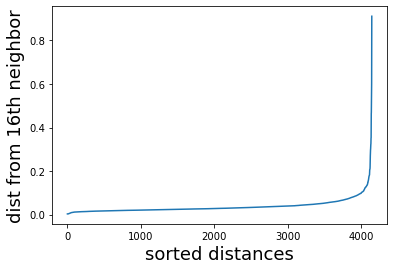

K = 16 
k-dist del 4000-esimo punto 0.10021909641008692: 
k-dist del 3000-esimo punto 0.03938412633823297: 


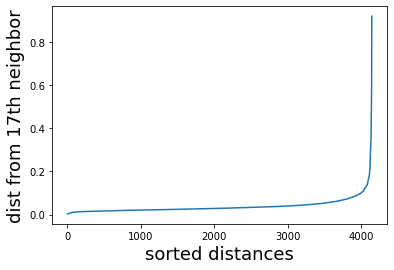

K = 17 
k-dist del 4000-esimo punto 0.10066477524027564: 
k-dist del 3000-esimo punto 0.03999798902936265: 


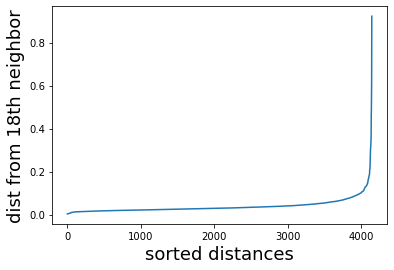

K = 18 
k-dist del 4000-esimo punto 0.10217233263775238: 
k-dist del 3000-esimo punto 0.04066481606465455: 


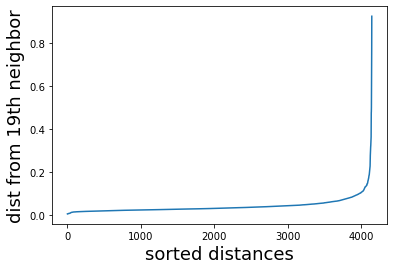

K = 19 
k-dist del 4000-esimo punto 0.10400887409538984: 
k-dist del 3000-esimo punto 0.04120995573493796: 


In [38]:
for k in range(2,20):

    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k] #indice della distanza che ordinata è in posizione k
        kth_distances.append(d[index_kth_distance])

        
    kth_distances=sorted(kth_distances)

    
    plt.plot(range(0, len(kth_distances)), kth_distances)
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.show()
    
    print("K = %d " % k)
    print("k-dist del 4000-esimo punto %s: " % kth_distances[4000])
    print("k-dist del 3000-esimo punto %s: " % kth_distances[3000])

# Subtask 3.2: cluster analysys

In [39]:
dbscan = DBSCAN(eps=0.08, min_samples=8)
dbscan.fit(X_DBScan)

print('Silhouette %s' % metrics.silhouette_score(X_DBScan, dbscan.labels_))

Silhouette 0.5820913975204165


In [40]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([  79, 4065], dtype=int64))

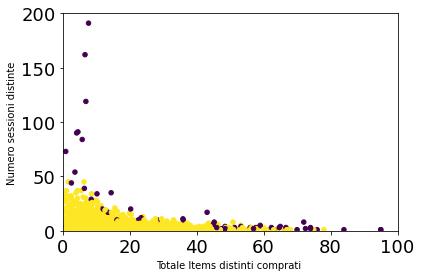

In [41]:
plt.scatter(X_DBScanForPrint['Iu'],X_DBScanForPrint['baskets'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.01, 100)
plt.ylim(-0.01,200)
plt.xlabel('Totale Items distinti comprati ')
plt.ylabel('Numero sessioni distinte')
plt.show()

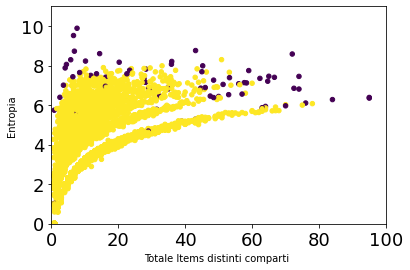

In [42]:
plt.scatter(X_DBScanForPrint['Iu'], X_DBScanForPrint['E'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.01, 100)
plt.ylim(-0.01,11)
plt.xlabel('Totale Items distinti comparti ')
plt.ylabel('Entropia')
plt.show()

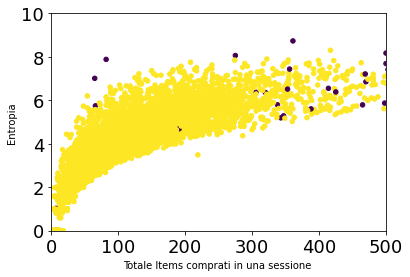

In [43]:
plt.scatter(X_DBScanForPrint['Imax'], X_DBScanForPrint['E'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0.01,500)
plt.ylim(-0.01,10)
plt.xlabel('Totale Items comprati in una sessione ')
plt.ylabel('Entropia')
plt.show()

la dimensione dello spazio elevata e l'alta densità dei punti fa si che si genera quasi un solo cluster

# Hierarchical clustering

Si sperimentano varie invocazioni dell'oggetto `AgglomerativeClustering` e come i clusters generati cambiano al variare delle metriche adottate.

In [18]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [19]:
from sklearn.cluster import AgglomerativeClustering

def hierarchical_clustering(X, levels):
    for linkage in {"average", "complete", "single", "ward"}:
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage)
        model.fit_predict(X)
        plt.figure(figsize=(15, 10))
        plot_dendrogram(model, truncate_mode='level', p=levels)
        plt.title(linkage)

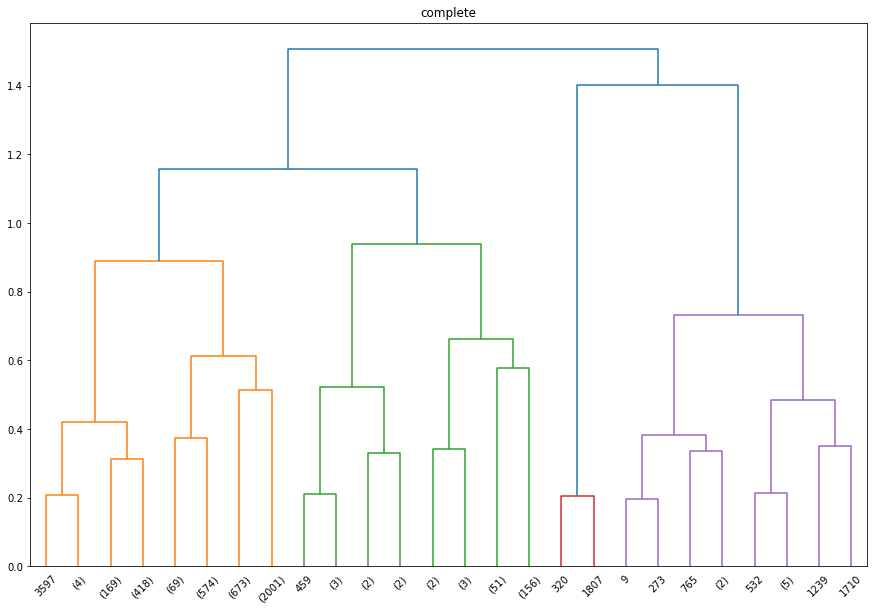

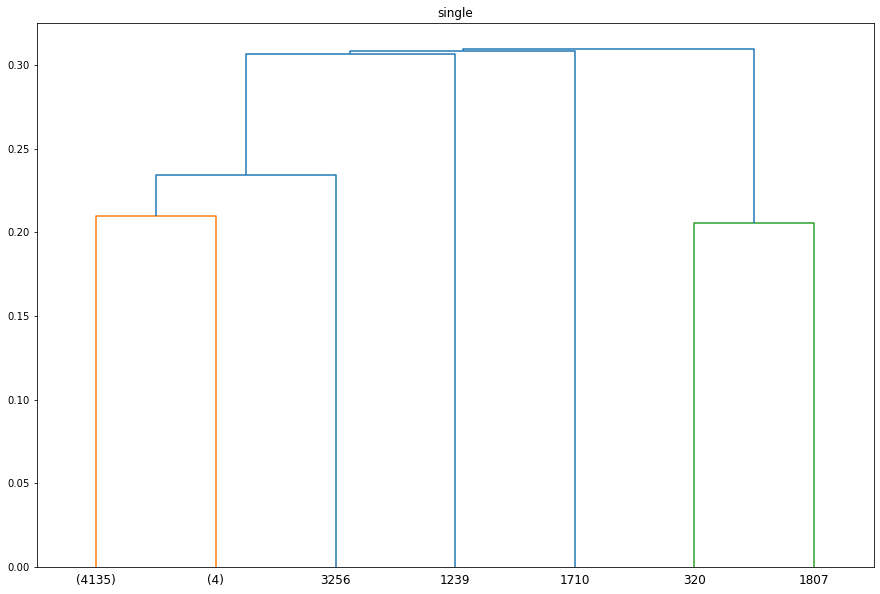

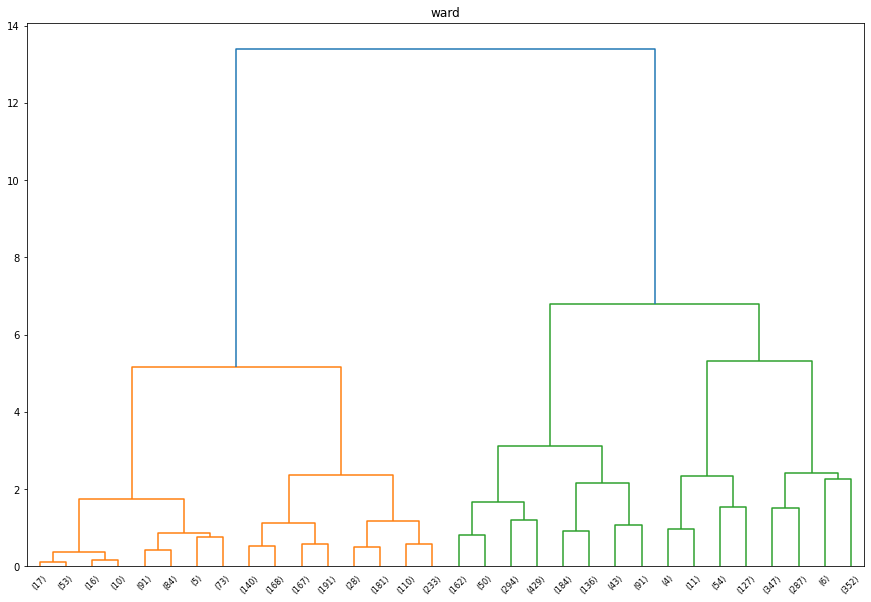

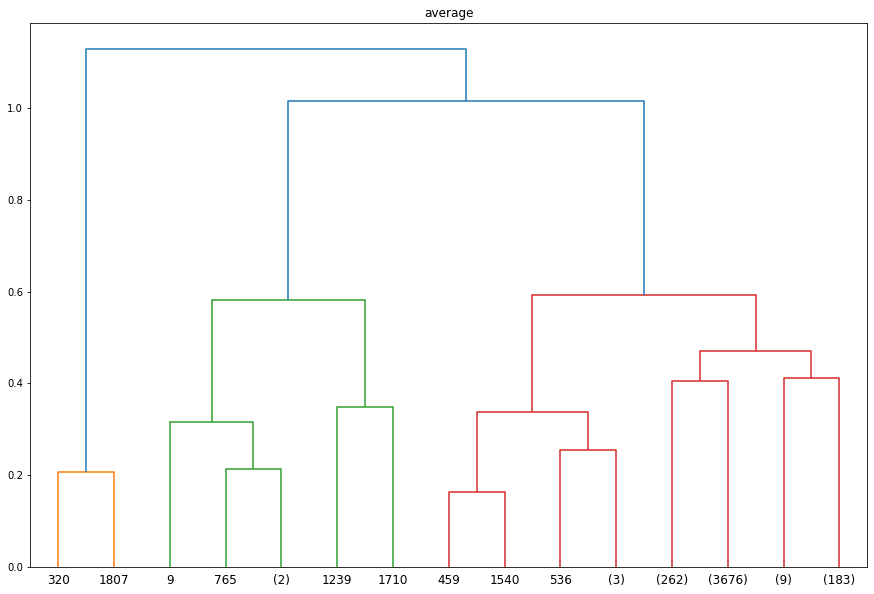

In [20]:
hierarchical_clustering(customer_indicators.values, 4)

In [21]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette


def xmeans_clustering(X, min_clusters, max_clusters):
    # Computes initial centers with kmeans++
    initial_centers = kmeans_plusplus_initializer(X, min_clusters).initialize()
    # Computes final clusters and centroids
    xmeans_instance = xmeans(X, initial_centers, max_clusters)
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    # Prints total sum of metric errors
    sse = xmeans_instance.get_total_wce()
    silhouette_score = silhouette(X, clusters).process().get_score()
    print(f"SSE: {sse}, Silhouette: {np.mean(silhouette_score)}")
    # Prints final number of clusters
    print("Total number of clusters: ", len(clusters))
    return clusters, centers

In [22]:
def list_to_labels(X, clusters):
    labels = np.zeros(X.shape[0])
    for i in range(len(clusters)):
        for point in clusters[i]:
            labels[point] = i
    return labels

In [23]:
clusters, centers = xmeans_clustering(customer_indicators.values, min_clusters=2, max_clusters=6)
clusters = list_to_labels(customer_indicators.values, clusters)
clusters

SSE: 40.23718536855768, Silhouette: 0.4626251182145254
Total number of clusters:  6


array([2., 5., 3., ..., 4., 1., 0.])

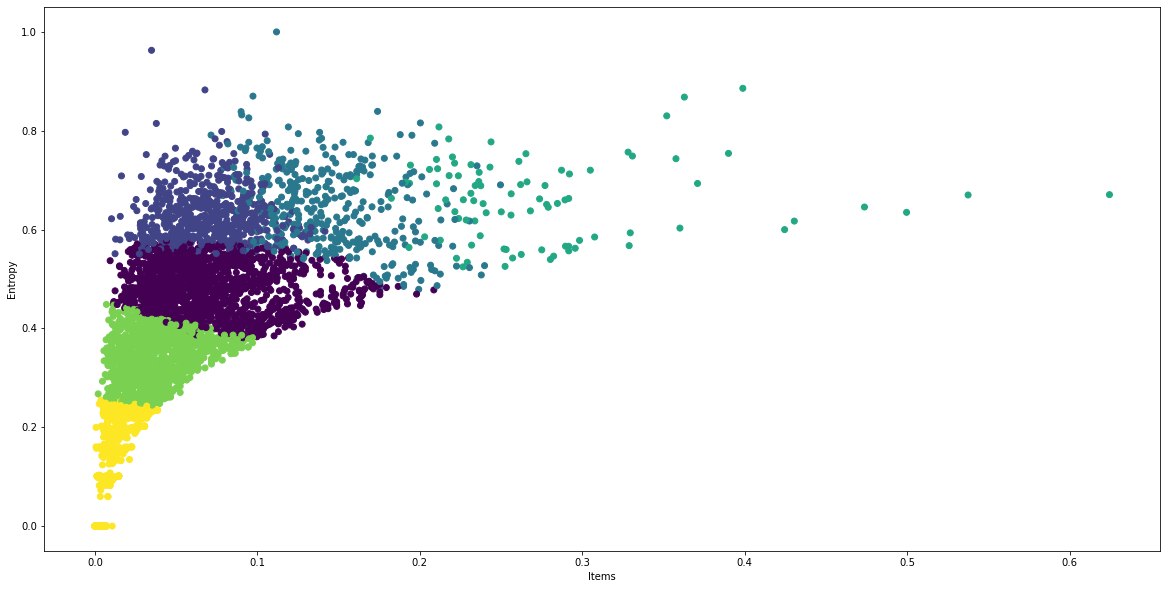

In [24]:
plt.figure(figsize=(20, 10))
plt.xlabel("Items")
plt.ylabel("Entropy")
plt.scatter(
    x = customer_indicators["I"],
    y = customer_indicators["E"],
    c = clusters
)

In [17]:
customer_indicators.to_csv("../../indicators.csv")